<h1 align="center"> Credit card Fraud Detector </h1>


<h2> Введение </h2>

На данной практие (и еще на парочке занятий потом) мы будем реализовывать различные прогностические модели, чтобы проверить, насколько точно они определяют, является ли транзакция обычным платежом (non Fraud) или мошенничеством (Fraud).

<h4> По мотивам кейса, рассмотренного в Зимней школе СберУнивера </h4>

<h2> Наши цели: </h2>
<ul>
<li> Проанализировать полученные данные. </li>
<li> Рассмотреть проблему сильного дисбаланса классов. </li>
<li> Использовать алгоритмы кластеризации </li>
<li> Использовать алгоритмы понижения размерности </li>


## Описание данных и постановка задачи:
**Задача:** Банкам, выпускающим кредитные карты, очень важно распознавать мошеннические операции с кредитными картами, чтобы с клиентов не взималась плата за товары, которые они не покупали.

**Данные**: Набор данных содержит транзакции, совершенные по кредитным картам в сентябре 2013 года европейскими держателями карт.
В этом наборе данных представлены транзакции, проведенные за два дня, где мы имеем 492 случаев мошенничества из 284 807 транзакций. Набор данных сильно несбалансирован, положительный класс (мошенники) составляет всего 0,172% от всех транзакций.

Датасет содержит только числовые входные переменные, которые являются результатом преобразования PCA (метод главных компонент).

Из-за вопросов конфиденциальности невозможно использовать исходные признаки и более подробную информацию о них. Характеристики V1, V2, ... V28 - это главные компоненты, полученные с помощью PCA, единственные характеристики, которые не были преобразованы с помощью PCA - это "Time" и "Amount". Столбец "Time" содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. Столбец "Amount" - это сумма транзакции. Столбец "Class" является переменной отклика и принимает значение 1 в случае мошенничества и 0 в противном случае.





In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import seaborn as sns
import matplotlib.patches as mpatches
import time

import collections
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# загрузка данных и структура данных
df=pd.read_csv('creditcard.csv')
df.head(285000)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Небольшой описательный анализ.

In [ ]:
# анализ данных
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Значения не нулевые, числовые

Проверим на наличие пропусков в данных.

In [ ]:
# проверка наличия пропусков в данных
df.isnull().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0



Пропусков нет


Выведем названия столбцов.

In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Еще раз оценим отношение классов целевой переменной.

In [ ]:
# вывод на печать 'Обычные транзакции составляют' и 'Мошеннические транзакции составляют' в процентном соотношении

# Подсчет классов
classp = df['Class'].value_counts()
print(classp)
# Вычисление процентного соотношения
prsoot = (classp / classp.sum()) * 100

print("Процентное соотношение классов:")
print(prsoot)

Class
0    284315
1       492
Name: count, dtype: int64
Процентное соотношение классов:
Class
0    99.827251
1     0.172749
Name: count, dtype: float64


In [ ]:
#  вывод отношения классов целевой переменной, но записанный через f строку

n_trans = prsoot[0]
f_trans = prsoot[1]

print(f'Обычные транзакции составляют  {n_trans} % данных')
print(f'Мошеннические транзакции составляют  {f_trans} % данных')

Обычные транзакции составляют  99.82725143693798 % данных
Мошеннические транзакции составляют  0.1727485630620034 % данных


**Важно!**

Обратите внимание, насколько несбалансированным является наш исходный набор данных! Большинство транзакций не являются мошенническими. Если мы используем этот массив данных в качестве основы для наших моделей прогнозирования и анализа, мы можем получить много ошибок, поскольку наши алгоритмы будут предполагать, что все транзакции не являются мошенничеством. Нам же критически важно сконцентрироваться именно на мошенниках.

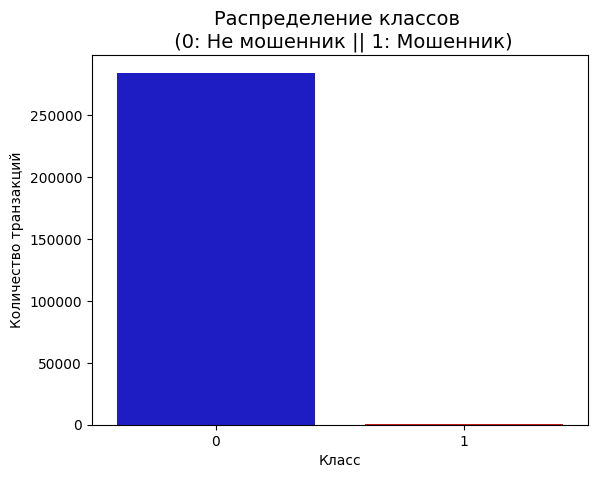

In [ ]:
colors = ["#0101DF", "#DF0101"]
#sns.set_palette(sns.color_palette(colors))

 # строим гистограмму целевой переменной:
sns.countplot(x='Class', data=df, palette=colors)
plt.title('Распределение классов \n (0: Не мошенник || 1: Мошенник)', fontsize=14)
plt.xlabel('Класс')
plt.ylabel('Количество транзакций')
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.show()

Построим распределения по суммам и времени транзакций.

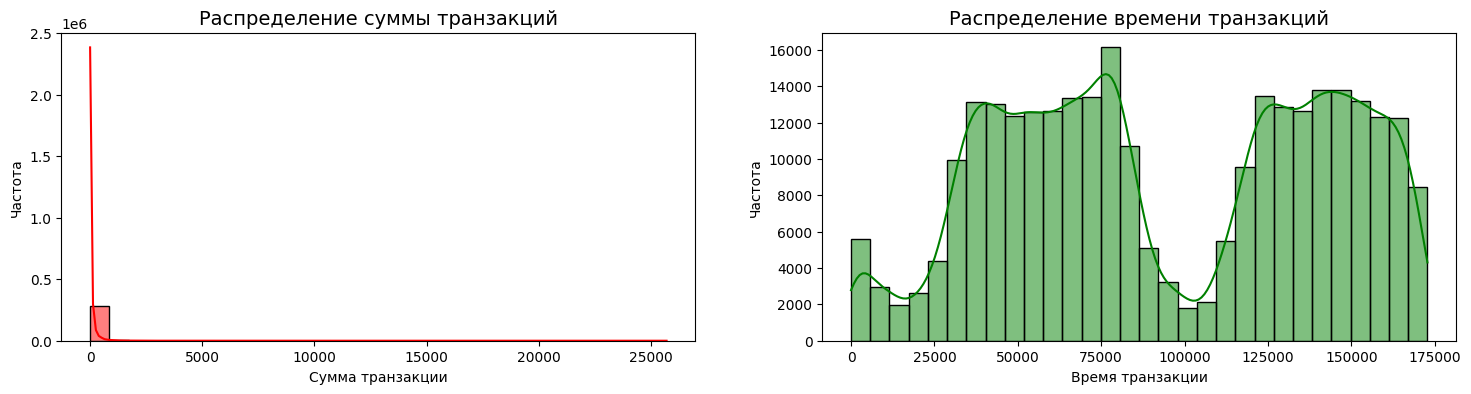

In [ ]:
# Создаем фигуру с двумя графиками
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

amount_val = df['Amount']
time_val = df['Time']

# График распределения суммы транзакций
sns.histplot(amount_val, ax=ax[0], color='red', bins=30, kde=True) # kde -  оценка плотности распределения
ax[0].set_title('Распределение суммы транзакций', fontsize=14)
ax[0].set_xlabel('Сумма транзакции')
ax[0].set_ylabel('Частота')

# График распределения времени транзакций
sns.histplot(time_val, ax=ax[1], color='green', bins=30, kde=True)
ax[1].set_title('Распределение времени транзакций', fontsize=14)
ax[1].set_xlabel('Время транзакции')
ax[1].set_ylabel('Частота')

plt.show()

### Масштабирование
Первым делом нам необходимо отмасштабировать столбцы **Time** и **Amount**. Поскольку все остальные признаки уже отмасштабированы. Однако делать это нужно только строго **после** разбиения на обучающую выборку и тестовую.

Затем необходимо создать подвыборку из наших данных, чтобы иметь равное количество случаев мошенничества и не мошенничества, что поможет нашим моделям лучше понять закономерности, определяющие, является ли транзакция мошенничеством или нет.

### Зачем создавать подвыборку?
Наши данные имеют сильный дисбаланс. Использование исходного датасета приведет к следующим проблемам:
  - **Переобучение**: Наши модели классификации будут предполагать, что в большинстве случаев мошенничества не существует! Мы хотим, чтобы наша модель точно определяла, когда происходит мошенничество.
  - **Неверные корреляции:** Хотя мы не знаем, что обозначают признаки "V", будет полезно понять, как каждый из этих признаков влияет на результат (мошенничество или отсутствие мошенничества), поскольку, имея несбалансированный набор данных, мы не можем увидеть истинные корреляции между целевой переменной и признаками.

### Разделение данных
**Важно!**

Прежде, чем приступить к балансировке наших данных, мы должны разделить исходный набор данных. Зачем?

Для определения качества работы наших моделей их необходимо тестировать на **исходном** тестовом наборе, а не на тестовом наборе, созданном после балансировки. Цель балансировки заключается в том, чтобы модель смогла найти закономерности для принятия решения по типу транзакции, поэтому мы выравниваем соотношение между мошенническими транзакциями и обычными. Однако проверять качество мы будем именно в "боевых" условиях с учетом реального распределения данных.




In [ ]:
from sklearn.model_selection import train_test_split
# Поскольку большая часть наших данных уже масштабирована, мы должны масштабировать столбцы,
# которые остались (Amount и Time)
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler() # Менее чувствителен к выбросам, чем просто стандартизация

X = df.drop('Class', axis=1)
y = df['Class']

original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2,
                                                                                    random_state = 42)


# Посмотрим, какие типы данных возвращаются после разделения:
rt_tmp = original_Xtrain['Amount']
print (f'Тип данных original_Xtrain["Amount"] {type(rt_tmp)}')
print (f'Тип данных original_Xtrain["Amount"].values {type(rt_tmp.values)}')
print (f'Данные original_Xtrain["Amount"].values {rt_tmp.values}')
print (f'Тип данных original_Xtrain["Amount"].values.reshape(-1,1) {type(rt_tmp.values.reshape(-1,1))}')
print (f'Данные original_Xtrain["Amount"].values.reshape(-1,1) \n{rt_tmp.values.reshape(-1,1)} \n')

# вот последнее представление - как раз то, что нужно для RobustScaler . Преобразовываем так все нужные столбцы.

original_Xtrain['scaled_amount'] = rob_scaler.fit_transform(original_Xtrain['Amount'].values.reshape(-1,1))
original_Xtest['scaled_amount'] = rob_scaler.transform(original_Xtest['Amount'].values.reshape(-1,1))

original_Xtrain['scaled_time'] = rob_scaler.fit_transform(original_Xtrain['Time'].values.reshape(-1,1))
original_Xtest['scaled_time'] = rob_scaler.transform(original_Xtest['Time'].values.reshape(-1,1))

original_Xtrain.drop(['Time','Amount'], axis=1, inplace=True)
original_Xtest.drop(['Time','Amount'], axis=1, inplace=True)

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Распределение классов: \n')
print("Обучающий набор:", train_counts_label/ len(original_ytrain))
print("Тестовый набор:", test_counts_label/ len(original_ytest))

Тип данных original_Xtrain["Amount"] <class 'pandas.core.series.Series'>
Тип данных original_Xtrain["Amount"].values <class 'numpy.ndarray'>
Данные original_Xtrain["Amount"].values [  9.99  45.9   11.99 ...   3.94   1.   113.  ]
Тип данных original_Xtrain["Amount"].values.reshape(-1,1) <class 'numpy.ndarray'>
Данные original_Xtrain["Amount"].values.reshape(-1,1) 
[[  9.99]
 [ 45.9 ]
 [ 11.99]
 ...
 [  3.94]
 [  1.  ]
 [113.  ]] 

Распределение классов: 

Обучающий набор: [0.99827075 0.00172925]
Тестовый набор: [0.99827955 0.00172045]


## Метод Random Under-Sampling

Применим метод *Random Under-Sampling*, который случайным образом удаляет объекты доминирующего класса и выравнивает соотношение классов.

#### Алгоритм:
<ul>
<li>Определяем степень несбалансированности (посчитали количество меток одного и другого класса выше)  </li>
<li>Как только мы определим, сколько случаев считаются мошенническими операциями (Fraud = "1"), мы должны довести количество немошеннических операций до того же количества, что и мошеннических (мы хотим получить соотношение 50/50 между классами), то есть это в подвыборке будет 492 случая мошенничества и 492 случая немошеннических операций.  </li>
<li> После применения этого метода мы получим подвыборку нашего набора данных с соотношением 50/50 в отношении наших классов. Наконец, не забудем <b>перемешать</b> наши данные для того, чтобы модели не зависили от порядка входных данных.</li>
</ul>

**Важно!**

Основная проблема данного метода заключается в том, что мы рискуем тем, что наши модели классификации не будут работать так точно, как нам хотелось бы, поскольку происходит большая потеря информации (выделение всего 492 немошеннических транзакций из 284 315 немошеннических транзакций).

In [ ]:
# Поскольку наши классы сильно не сбалансированы, мы должны сделать их эквивалентными,
# чтобы получить нормальное распределение классов.

# Перемешаем данные перед созданием подвыборок

df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492] # берем последние 492 транзакции

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Перемешивание строк датасета
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head(1000)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
109004,71171.0,-1.765727,0.810192,-0.989786,-1.830301,0.454538,4.582058,-1.695609,-0.788784,0.123763,...,-1.333425,0.038244,0.338824,1.056435,-0.832775,0.648399,-0.176700,-0.000757,159.09,0
107637,70536.0,-2.271755,-0.457655,-2.589055,2.230778,-4.278983,0.388610,0.102485,0.813128,-1.092921,...,1.096342,0.658399,1.711676,0.333540,0.538591,-0.193529,0.258194,0.247269,824.83,1
86110,61085.0,-1.301050,-0.095646,1.387746,-0.815151,0.778871,-1.107402,0.697040,0.014082,-0.481684,...,0.077823,-0.205705,-0.006441,0.102460,0.372565,0.966306,-0.123233,0.050627,72.90,0
30384,35899.0,-2.857170,4.045601,-4.197299,5.487199,-3.070776,-1.422686,-5.651314,2.019657,-5.015491,...,1.080323,-0.561384,0.102678,-0.067195,-0.476931,-0.103716,1.166961,0.663632,1.00,1
149874,92102.0,-1.662937,3.253892,-7.040485,2.266456,-4.177649,-0.746925,-0.248337,1.091157,-0.307137,...,0.450381,0.521162,0.308325,-0.318012,-1.255362,-0.691963,0.264878,-0.130445,600.73,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42936,41305.0,-12.980943,6.720508,-13.455636,8.698610,-11.479552,-2.681519,-14.019291,8.218191,-7.930900,...,2.549628,-0.532228,-0.235096,0.673209,0.226598,-0.006168,-1.185696,-0.747361,59.68,1
102443,68207.0,-13.192671,12.785971,-9.906650,3.320337,-4.801176,5.760059,-18.750889,-37.353443,-0.391540,...,27.202839,-8.887017,5.303607,-0.639435,0.263203,-0.108877,1.269566,0.939407,1.00,1
51246,44856.0,-1.302577,0.361498,1.370132,0.780659,-0.026212,1.803487,0.028958,0.869027,-0.878932,...,0.305356,0.420403,-0.025887,-1.711042,0.371538,-0.069332,-0.035511,-0.023400,180.00,0
243848,152098.0,-4.124316,3.748597,-7.926507,7.763242,-0.769375,-2.031171,-3.474549,0.107121,-1.551352,...,0.547097,0.687854,0.429939,-0.620601,-0.369688,0.367349,-2.664767,0.417101,1.00,1


In [ ]:
df.to_csv("creditcard.csv")

In [ ]:
new_df.shape

(984, 31)

Распределение классов в подвыборке


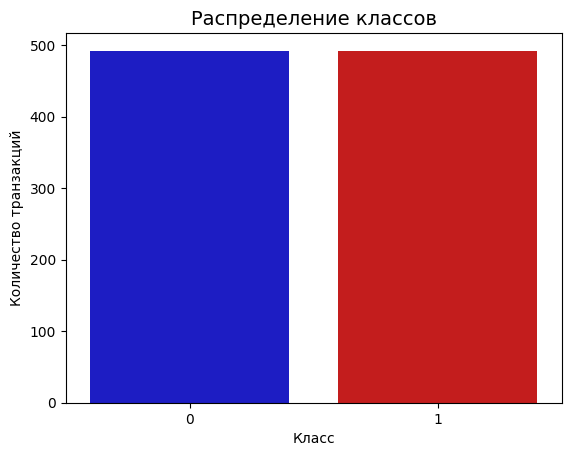

In [ ]:
print('Распределение классов в подвыборке')
colors = ["#0101DF", "#DF0101"]


# проверяем снова распределение целевой переменной

sns.countplot(x='Class', data=new_df, palette=colors)
#sns.set_palette(sns.color_palette(colors))
plt.title('Распределение классов', fontsize=14)


plt.xlabel('Класс')
plt.ylabel('Количество транзакций')
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.show()


### Матрица корреляций

Корреляционные матрицы очень важны для понимания данных. Мы хотим узнать, есть ли признаки, которые оказывают сильное влияние на то, является ли конкретная транзакция мошенничеством. Однако важно, чтобы мы использовали сбалансированную подвыборку, чтобы увидеть, какие признаки имеют высокую положительную или отрицательную корреляцию в отношении мошеннических операций.


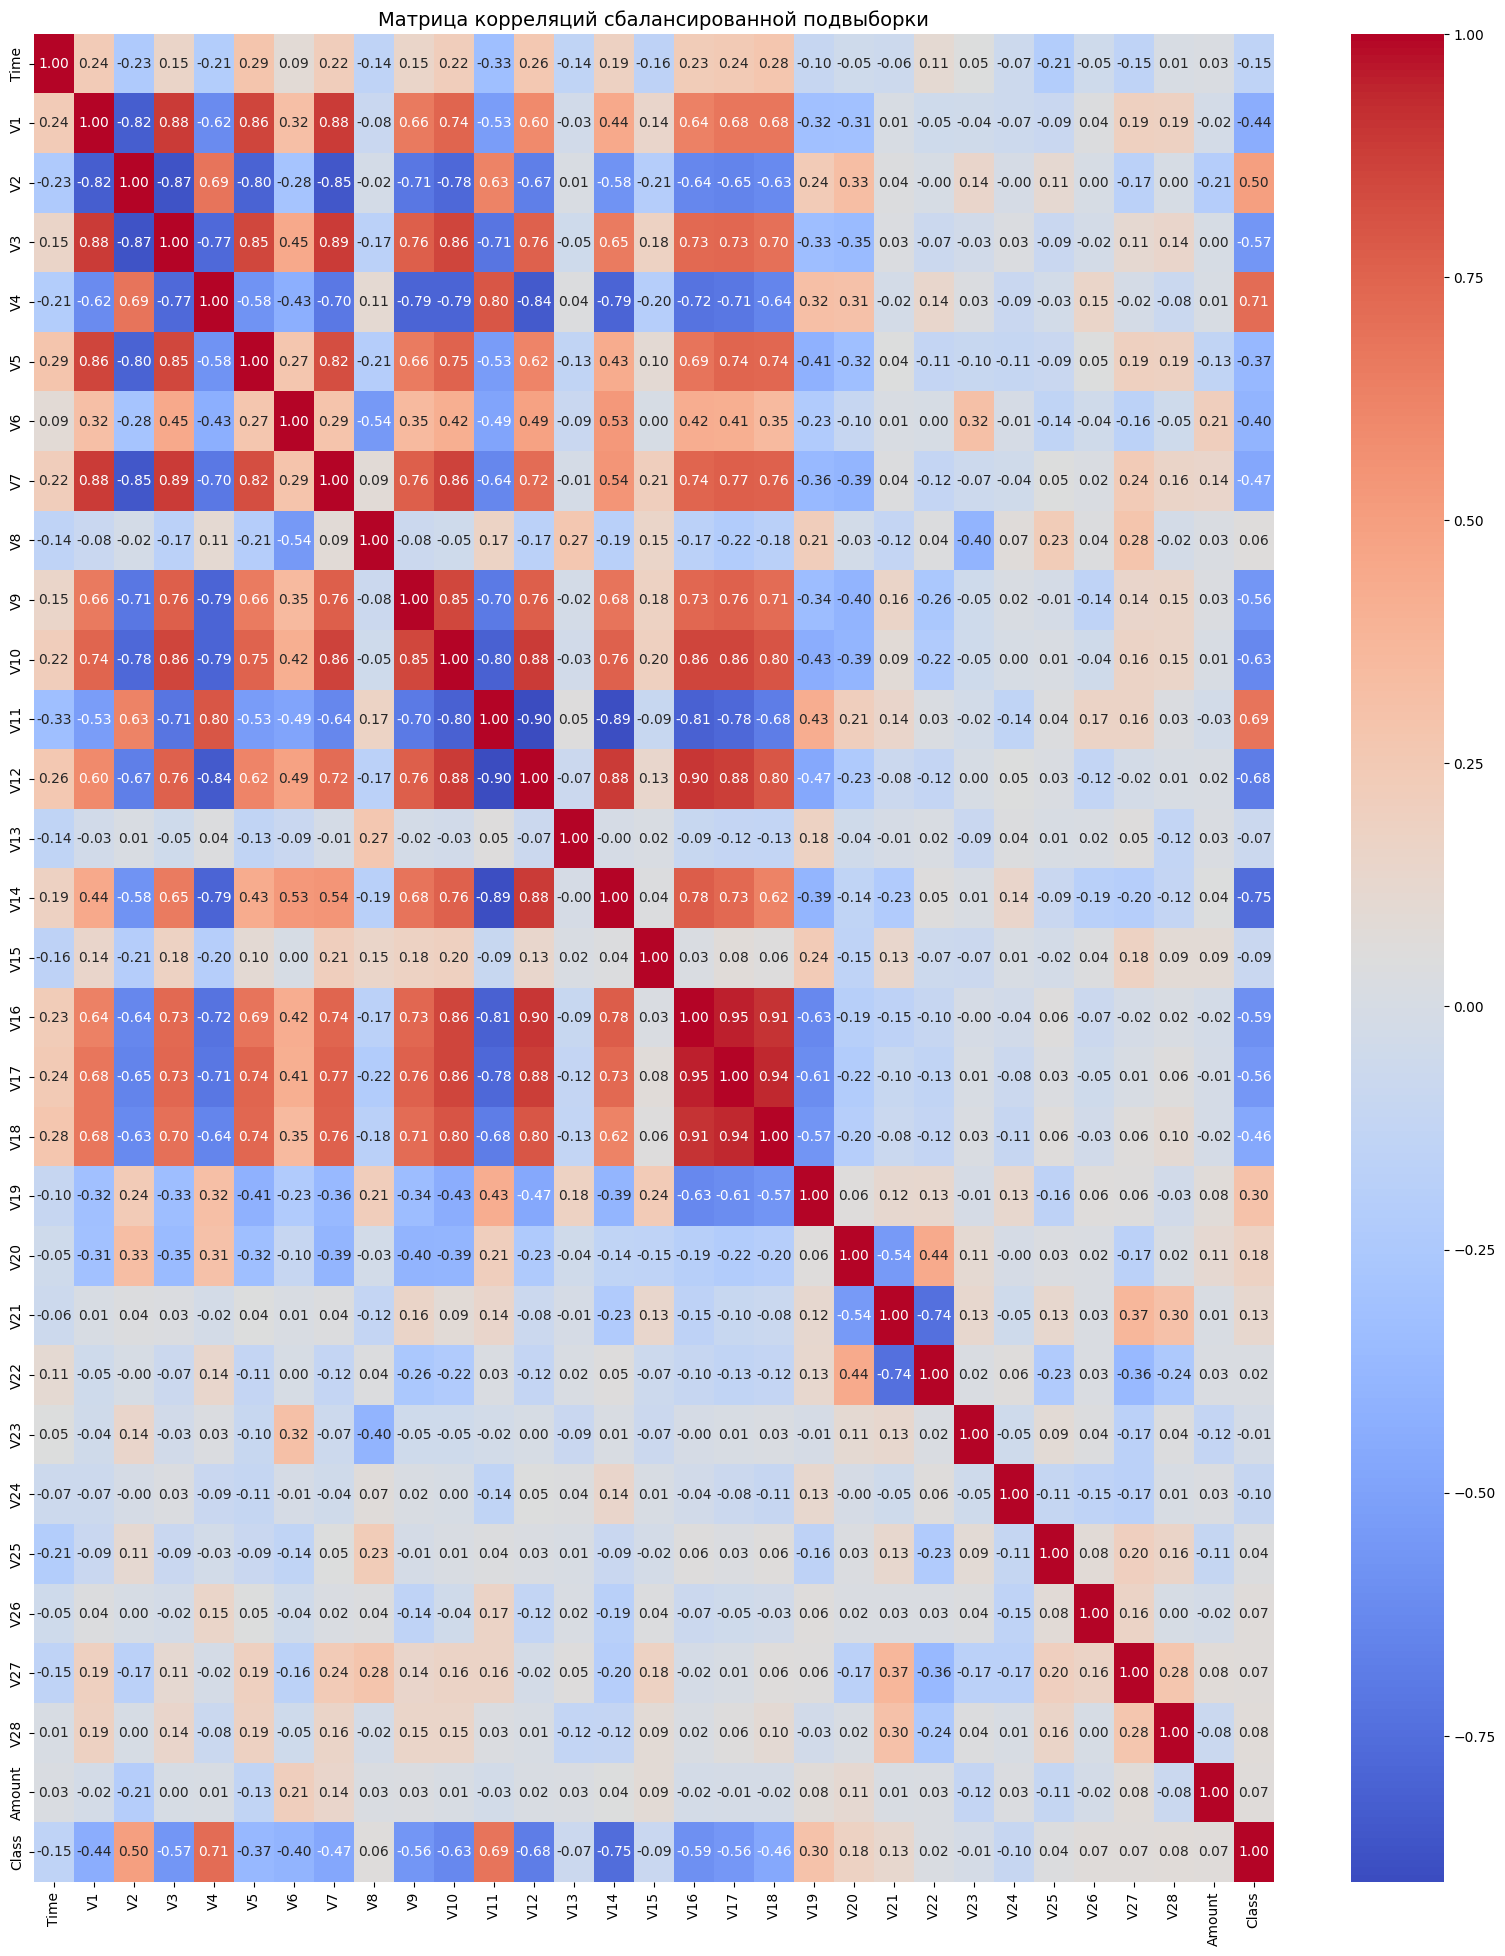

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(20, 24))

# Построим матрицу корреляций
plt.figure(f)
sns.heatmap(new_df.corr(),annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Тепловая карта корреляции данных')

ax.set_title('Матрица корреляций сбалансированной подвыборки', fontsize=14)
plt.show()

### Выводы:
<ul>
<li><b>Отрицательные корреляции: </b> Какие признаки  имеют отрицательную корреляцию? Другими словами, чем ниже эти значения, тем больше вероятность того, что конечным результатом будет мошенническая операция.  </li>


<li> <b> Положительные корреляции: </b> Какие признаки  положительно коррелируют? То есть, чем выше эти значения, тем больше вероятность того, что конечным результатом будет мошенническая операция. </li>
</ul>

Отрицательную корреляцию имеют признаки - V14, V12

Положительную корреляцию имеют признаки - V4, V11


Построим теперь Boxplot.

Text(0.5, 1.0, 'Ящик с усами для V12')

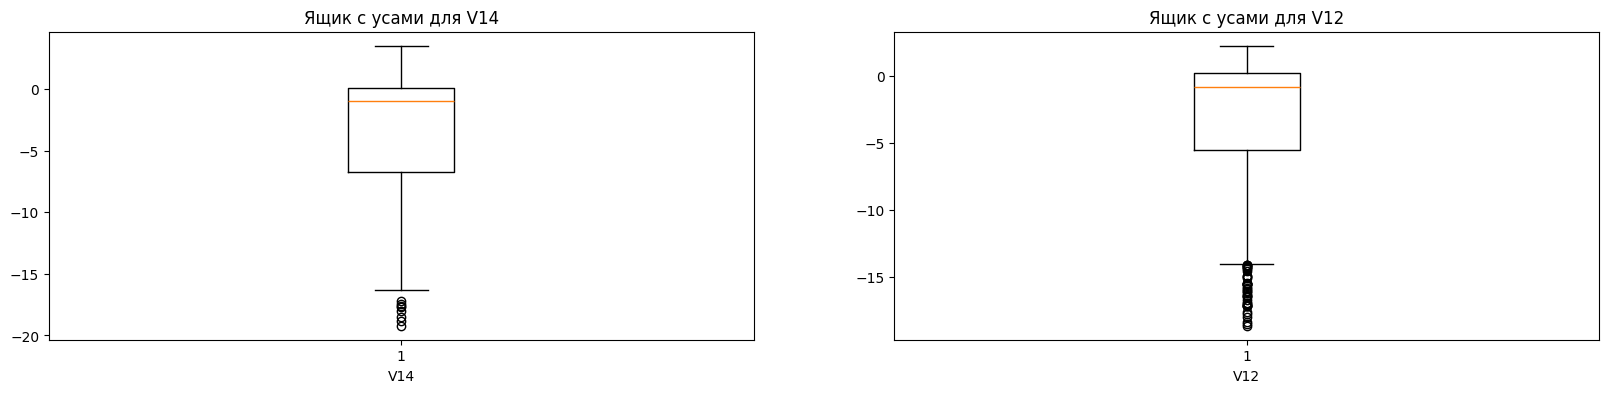

In [ ]:
f, axes = plt.subplots(ncols=2, figsize=(20,4))
# Отрицательные корреляции
# Ящики с усами
## для V14
axes[0].boxplot(new_df['V14'])
axes[0].set_xlabel('V14')
axes[0].set_title('Ящик с усами для V14')
## для V12
axes[1].boxplot(new_df['V12'])
axes[1].set_xlabel('V12')
axes[1].set_title('Ящик с усами для V12')



Text(0.5, 1.0, 'Ящик с усами для V11')

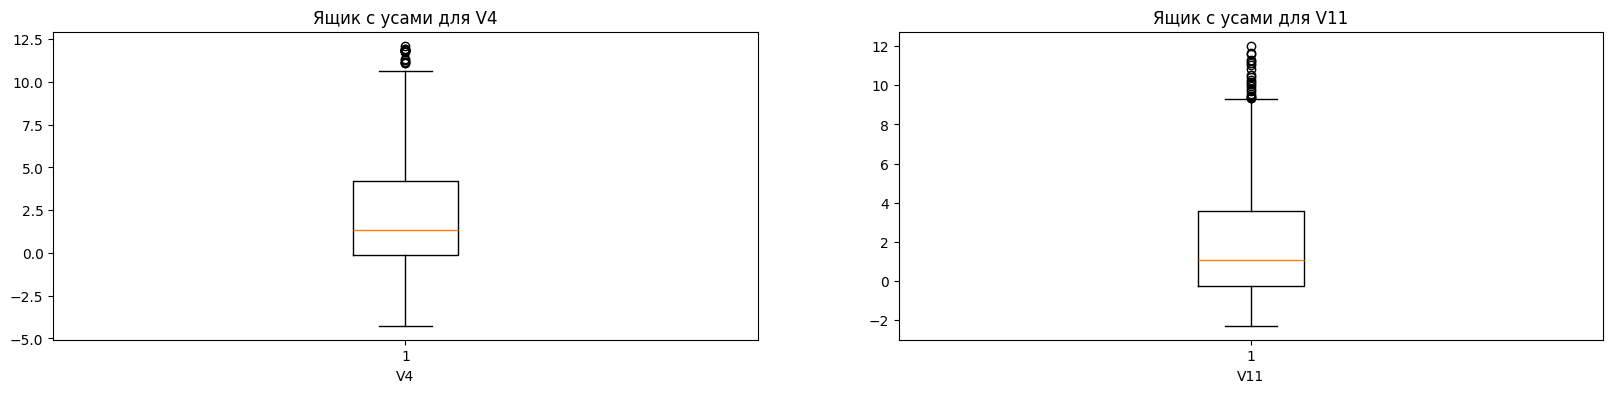

In [ ]:
f, axes = plt.subplots(ncols=2, figsize=(20,4))
# Положительные корреляции
# Ящики с усами
## для V4
axes[0].boxplot(new_df['V4'])
axes[0].set_xlabel('V4')
axes[0].set_title('Ящик с усами для V4')
## для V11
axes[1].boxplot(new_df['V11'])
axes[1].set_xlabel('V11')
axes[1].set_title('Ящик с усами для V11')


# Какие выводы можно сделать по построенным Boxplot?

Большинство значений V4, V11, V14 и V4 находятся в пределах нуля

0 - это не мошеннические транзакции

1 - мошеннические транзакции

## Обработка выбросов

Наша основная цель в этом разделе - удалить выбросы из признаков, которые имеют высокую корреляцию с целевой переменной. Это положительно скажется на точности наших моделей.


### Метод межквартильного размаха:
<ul>
<li> <b>Interquartile Range (IQR): </b> Рассчитываем разницу между 75-м процентилем и 25-м процентилем. Наша цель - создать порог за пределами 75-го и 25-го процентилей, чтобы в случае, если какой-то экземпляр выборки преодолеет этот порог, он был удален.  </li>
<li> <b>Построить Boxplots: </b> С помощью boxplot легко увидеть 25-й и 75-й процентили и выбросы. </li>
</ul>

Надо быть внимательным к тому, как далеко мы хотим установить порог для удаления выбросов. Мы определяем порог путем умножения числа (например, 1.5) на интерквартильный размах. Чем выше этот порог, тем меньше выбросов будет обнаружено, а чем ниже этот порог, тем больше выбросов будет обнаружено.  <br><br>

Мы хотим больше сосредоточиться именно на сильных выбросах, а не просто на выбросах. Почему? Потому что удалив все выбросы, мы можем столкнуться с риском потери информации, что приведет к снижению точности наших моделей.


### Итого:
<ul>
<li> <b> Строим распределения </b>  </li>
<li><b>Определяем порог </b> </li>
<li> <b>Удаляем выбросы </b> </li>
<li> <b> Строим Boxplot </b> </li>
</ul>

Text(0.5, 1.0, 'Распределение V12')

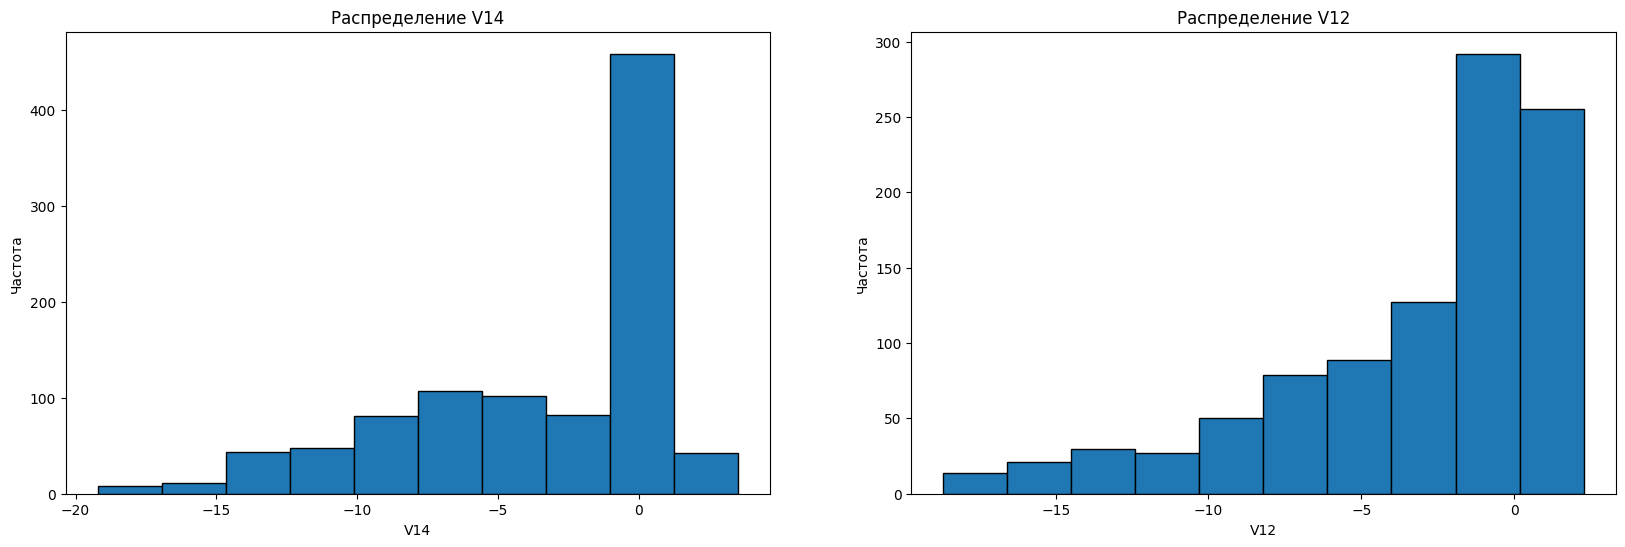

In [ ]:
# Строим распределения для признаков с отрицательной корреляцией
from scipy.stats import norm

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))
####Гистограмма для V14
ax1.hist(new_df['V14'], bins=10, edgecolor='black')
ax1.set_xlabel('V14')
ax1.set_ylabel('Частота')
ax1.set_title('Распределение V14')

####Гистограмма для V12
ax2.hist(new_df['V12'], bins=10, edgecolor='black')
ax2.set_xlabel('V12')
ax2.set_ylabel('Частота')
ax2.set_title('Распределение V12')




In [ ]:
# Удаление выбросов из признака a


def udali(a):
   a_fraud = new_df[a].loc[new_df['Class'] == 1].values
   q25, q75 = np.percentile(a_fraud, 25), np.percentile(a_fraud, 75)
   print('Квартиль 25: {} | Квартиль 75: {}'.format(q25, q75))
   a_iqr = q75 - q25
   print('iqr: {}'.format(a_iqr))

   a_cut_off = a_iqr * 1.5
   a_lower, a_upper = q25 - a_cut_off, q75 + a_cut_off
   print('Порог: {}'.format(a_cut_off))
   print('a нижняя граница: {}'.format(a_lower))
   print('a верхняя граница: {}'.format(a_upper))

   outliers = [x for x in a_fraud if x < a_lower or x > a_upper]
   print('Количество выбросов: {}'.format(len(outliers)))

   global new_df_without_outliers


   new_df_without_outliers  = new_df.drop(new_df[(new_df[a] > a_upper) | (new_df[a] < a_lower)].index)
   print('----' * 44)


   return(new_df_without_outliers)

Квартиль 25: -9.692722964972386 | Квартиль 75: -4.282820849486865
iqr: 5.409902115485521
Порог: 8.114853173228282
a нижняя граница: -17.807576138200666
a верхняя граница: 3.8320323237414167
Количество выбросов: 4
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Квартиль 25: -8.688176521812306 | Квартиль 75: -2.97408802538493
iqr: 5.714088496427376
Порог: 8.571132744641064
a нижняя граница: -17.25930926645337
a верхняя граница: 5.597044719256134
Количество выбросов: 6
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


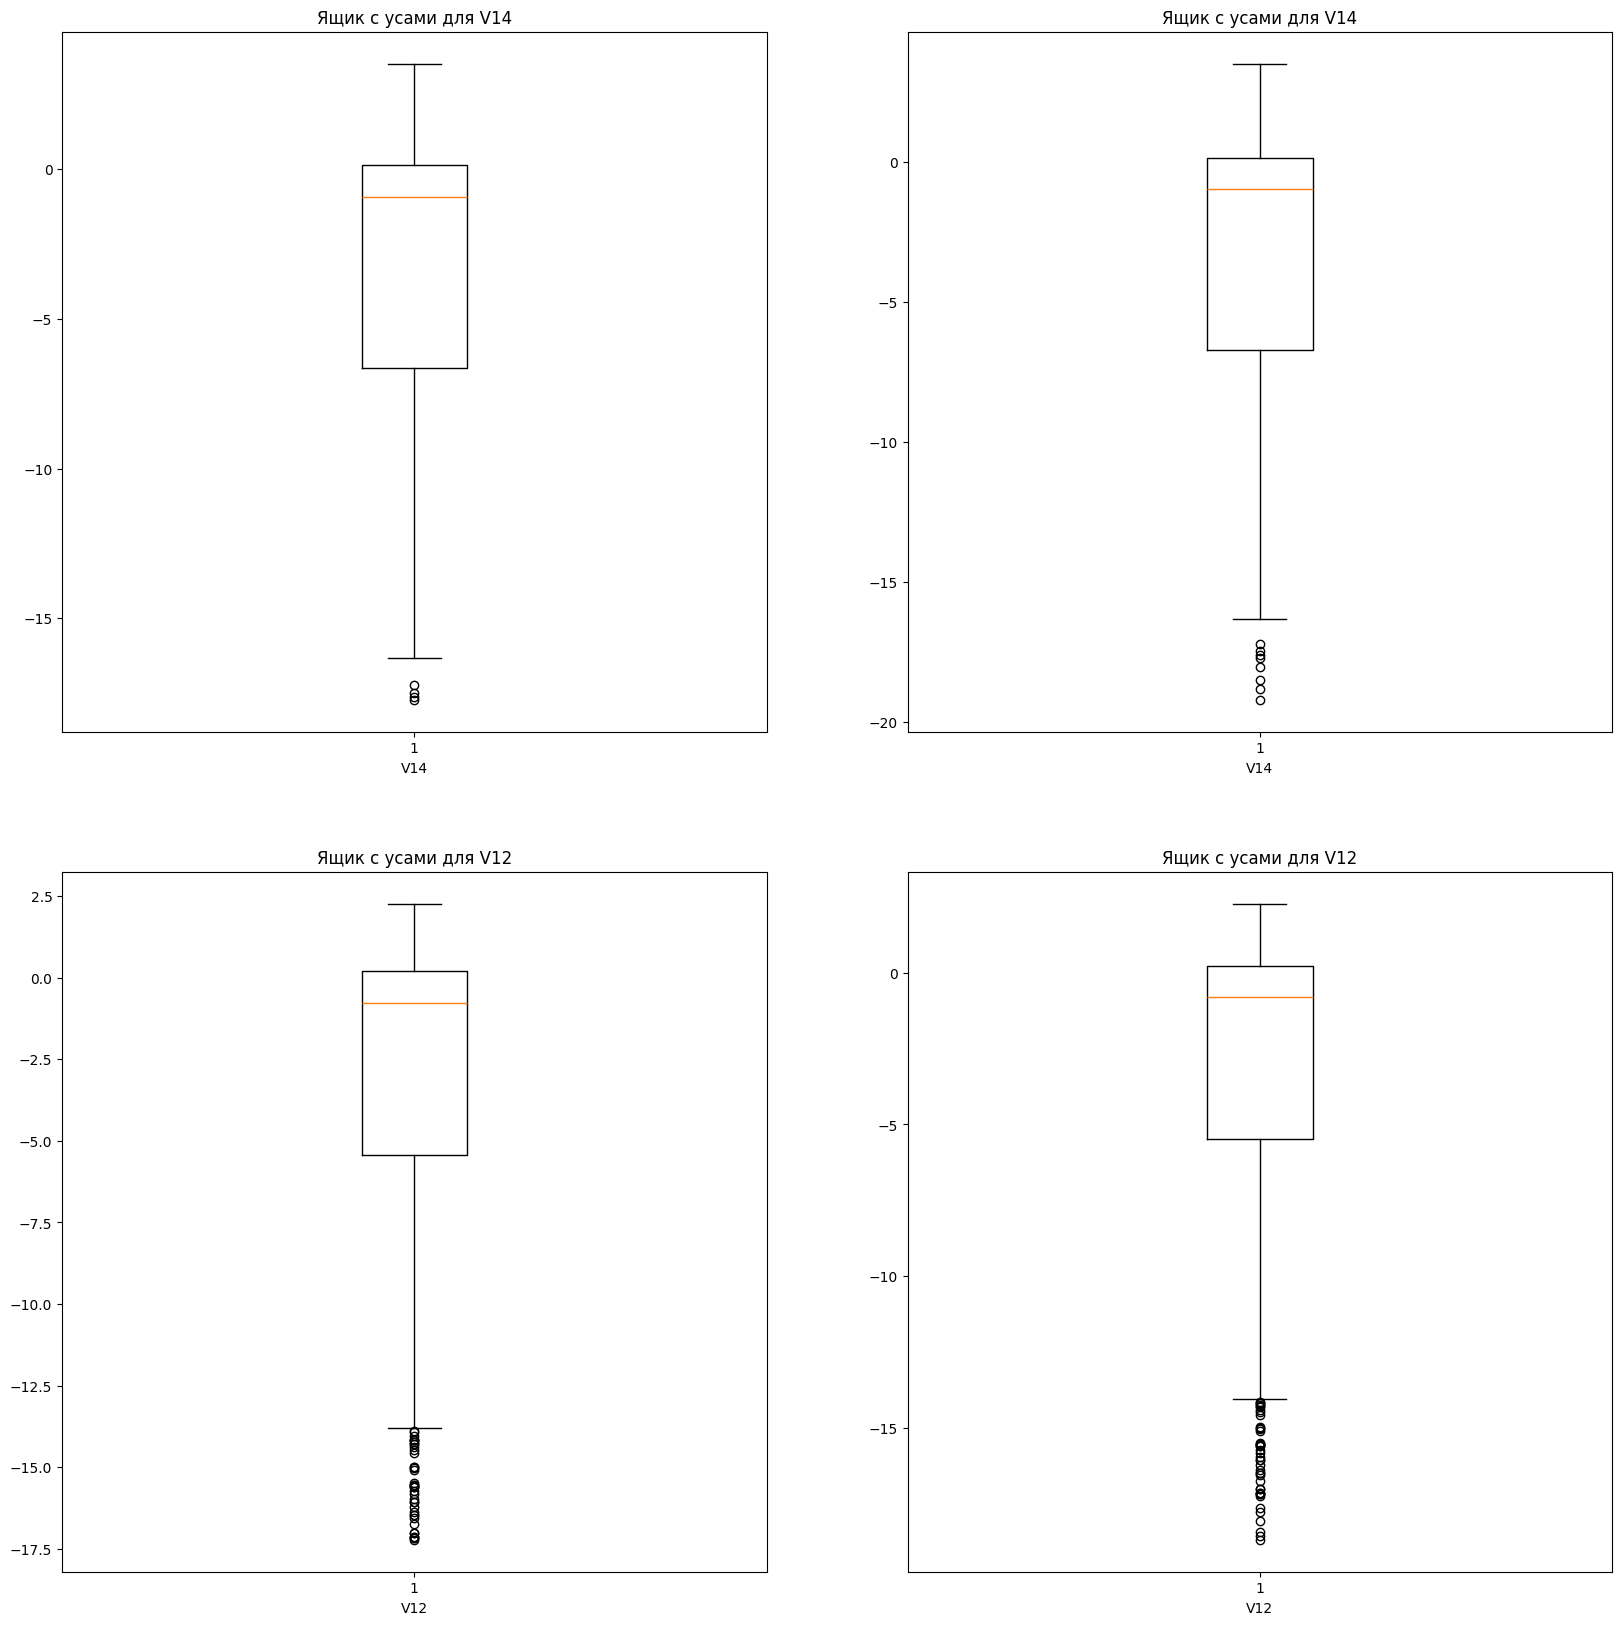

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(20,20))

colors = ['#B3F9C5', '#f9c5b3']

# Boxplot для признака V14 после удаления выбросов
ax[0,0].boxplot(udali('V14')['V14'])
ax[0,0].set_xlabel('V14')
ax[0,0].set_title('Ящик с усами для V14')

# Boxplot для признака V14 до удаления выбросов
ax[0,1].boxplot(new_df['V14'])
ax[0,1].set_xlabel('V14')
ax[0,1].set_title('Ящик с усами для V14')

# Boxplot для признака V12 после удаления выбросов
ax[1,0].boxplot(udali('V12')['V12'])
ax[1,0].set_xlabel('V12')
ax[1,0].set_title('Ящик с усами для V12')

# Boxplot для признака V12 до удаления выбросов
ax[1,1].boxplot(new_df['V12'])
ax[1,1].set_xlabel('V12')
ax[1,1].set_title('Ящик с усами для V12')



plt.show()

In [ ]:
# теперь у нас в датафрейме new_df будут лежать данные без выбросов.

new_df=new_df_without_outliers
new_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
109004,71171.0,-1.765727,0.810192,-0.989786,-1.830301,0.454538,4.582058,-1.695609,-0.788784,0.123763,...,-1.333425,0.038244,0.338824,1.056435,-0.832775,0.648399,-0.176700,-0.000757,159.09,0
107637,70536.0,-2.271755,-0.457655,-2.589055,2.230778,-4.278983,0.388610,0.102485,0.813128,-1.092921,...,1.096342,0.658399,1.711676,0.333540,0.538591,-0.193529,0.258194,0.247269,824.83,1
86110,61085.0,-1.301050,-0.095646,1.387746,-0.815151,0.778871,-1.107402,0.697040,0.014082,-0.481684,...,0.077823,-0.205705,-0.006441,0.102460,0.372565,0.966306,-0.123233,0.050627,72.90,0
30384,35899.0,-2.857170,4.045601,-4.197299,5.487199,-3.070776,-1.422686,-5.651314,2.019657,-5.015491,...,1.080323,-0.561384,0.102678,-0.067195,-0.476931,-0.103716,1.166961,0.663632,1.00,1
149874,92102.0,-1.662937,3.253892,-7.040485,2.266456,-4.177649,-0.746925,-0.248337,1.091157,-0.307137,...,0.450381,0.521162,0.308325,-0.318012,-1.255362,-0.691963,0.264878,-0.130445,600.73,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42936,41305.0,-12.980943,6.720508,-13.455636,8.698610,-11.479552,-2.681519,-14.019291,8.218191,-7.930900,...,2.549628,-0.532228,-0.235096,0.673209,0.226598,-0.006168,-1.185696,-0.747361,59.68,1
102443,68207.0,-13.192671,12.785971,-9.906650,3.320337,-4.801176,5.760059,-18.750889,-37.353443,-0.391540,...,27.202839,-8.887017,5.303607,-0.639435,0.263203,-0.108877,1.269566,0.939407,1.00,1
51246,44856.0,-1.302577,0.361498,1.370132,0.780659,-0.026212,1.803487,0.028958,0.869027,-0.878932,...,0.305356,0.420403,-0.025887,-1.711042,0.371538,-0.069332,-0.035511,-0.023400,180.00,0
243848,152098.0,-4.124316,3.748597,-7.926507,7.763242,-0.769375,-2.031171,-3.474549,0.107121,-1.551352,...,0.547097,0.687854,0.429939,-0.620601,-0.369688,0.367349,-2.664767,0.417101,1.00,1


### Понижение размерности и кластеризация

Для того, чтобы убедиться, что наши классы являются разделимыми (иначе строить модели нет смысла), выполним кластеризацию с помощью трех различных техник кластеризации.



In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

X = new_df.drop('Class', axis=1)
y = new_df['Class']

X.drop(['Time','Amount'], axis=1, inplace=True) # Tак как Time и Amount не коррелируют почти с таргетом


# T-SNE алгоритм
t0 = time.time()
tsne = TSNE(n_components=2, random_state=42)  # Создаем экземпляр TSNE с 2 компонентами
X_reduced_tsne = tsne.fit_transform(X)  # Применяем T-SNE к данным
t1 = time.time()
print("T-SNE заняло {:.2} сек".format(t1 - t0))

# PCA алгоритм
t0 = time.time()
pca = PCA(n_components=2)  # Создаем экземпляр PCA с 2 компонентами
X_reduced_pca = pca.fit_transform(X)  # Применяем PCA к данным
t1 = time.time()
print("PCA заняло {:.2} сек".format(t1 - t0))

# TruncatedSVD алгоритм
t0 = time.time()
svd = TruncatedSVD(n_components=2)  # Создаем экземпляр TruncatedSVD с 2 компонентами
X_reduced_svd = svd.fit_transform(X)  # Применяем TruncatedSVD к данным
t1 = time.time()
print("Truncated SVD заняло {:.2} сек".format(t1 - t0))

T-SNE заняло 7.4 сек
PCA заняло 0.0037 сек
Truncated SVD заняло 0.0042 сек


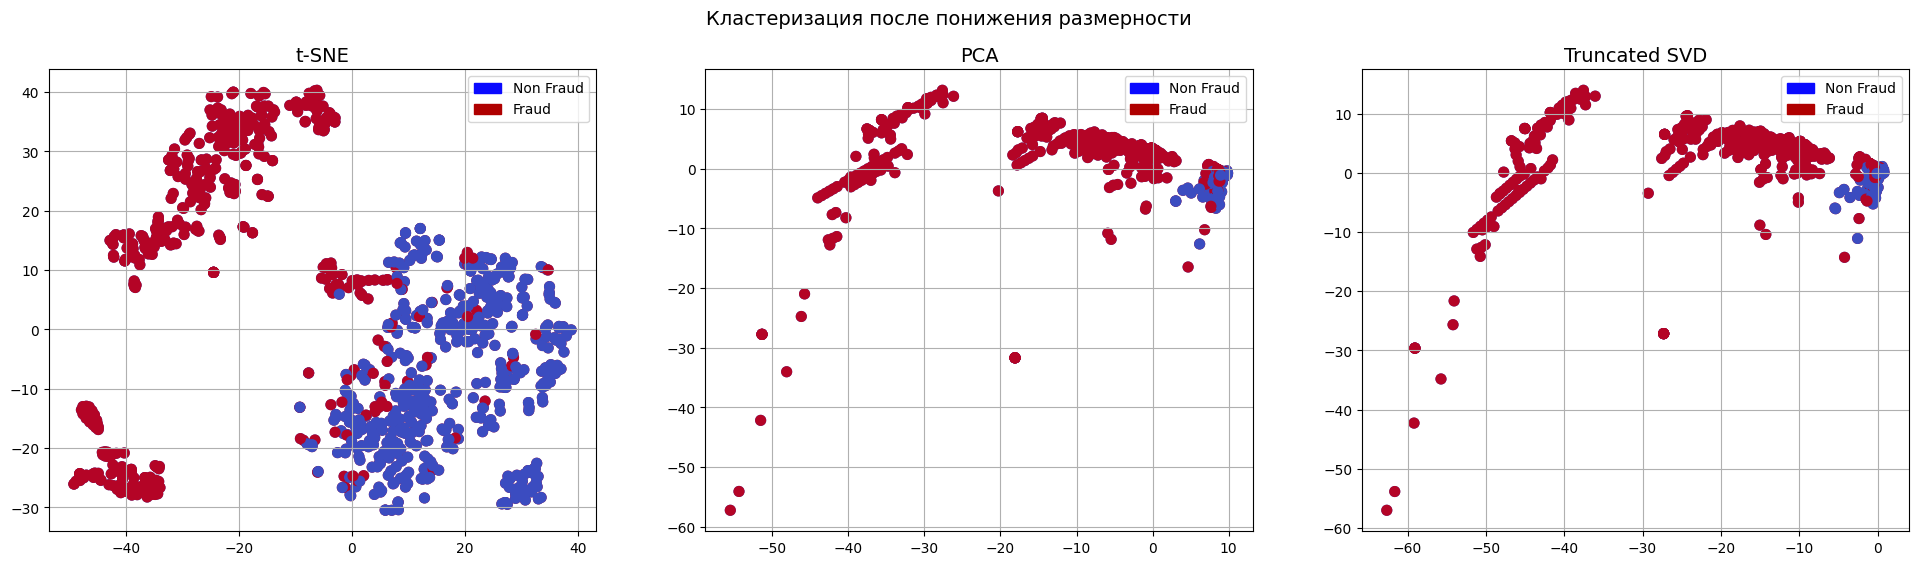

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
f.suptitle('Кластеризация после понижения размерности', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='Non Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])


plt.show()

<h3> Выводы: </h3>
<ul>
<li>Алгоритм t-SNE может довольно точно кластеризовать случаи мошенничества и не мошенничества в нашем наборе данных. </li>
<li> Классы целевой переменной однозначно разделимы, а значит мы можем строить модели! </li>
</ul>

## Продолжение следует .....

